# Plug flow coupling

## Introduction

The goal of this tutorial is to discuss a sequence of increasingly complex plug-flow reactor (PFR) models. These are all built upon `PlugFlowChainCantera` which approximates a PFR as a cascade of perfect-stirred reactors (PSR), as illustrated [here](https://cantera.org/stable/examples/python/reactors/pfr.html#sphx-glr-examples-python-reactors-pfr-py). Care must be taken when using such an approach because this zero-dimensional modeling does not formally represent a PFR, but approaches one - so grid convergence studies might be required to validate a model, what is beyond our scope here (and has been done during the conception of this report), which limits itself to studying the coupling of reactors. Nonetheless, this representation proves very interesting when assembling complex systems as it remains modular, allowing for extensibility of models.

In what follows we will be guided through the following models:

- A single PFR with possibility of distributed mass sources along its length; this case is often encountered in industry when modeling reactors coupled through a permeable membrane, or in a rotary kiln, where solids may eventually release gases, what is especially important in the field of biomatter gaseification.

- Next we will couple a pair of reactors as conceived in the first example, which will be allowed to exchange energy through a pseudo-convective model; there is no major difficulty at this point as the coupling can be stabilized through a relaxation routine. We investigate how the ordering of reactor solution affects convergence rate.

- At the last level of complexity studied here, we add a shared common wall around the pair of reactors of the previous step; one might argue that such a system would require two *wall* temperatures to be described at steady state; here we will assume that this wall is *rotating* around the pair of reactors in such a way that it remains in contact with a reactor during part of a cycle, and a *statistically significant mean temperature* is solely used as a process measurable.

Because writting long classes is not didatic for the purposes of a tutorial, we will use a *semi-object-oriented* programming approach here. That means, there will be minimal classes just holding the basic elements representing the state of a problem, and functions that resemble class methods (receiving the class instance as first argument) to perform the required operations.

Below we start by importing all required tools at once:

In [1]:
%load_ext autoreload
%autoreload 2

%load_ext majordome.skipper

In [2]:
from majordome import (PlugFlowChainCantera, RelaxUpdate,
                       StabilizeNvarsConvergenceCheck,
                       ComposedStabilizedConvergence,
                       standard_plot, get_reactor_data)

from numpy.typing import NDArray
from tabulate import tabulate
import os
import logging
import cantera as ct
import numpy as np

In [3]:
logging.basicConfig(level=logging.INFO, force=True)

Because some cells take some time to execute, during development you can set this to `"true"` so that they are not run. You can recognize these cells by the presence of magic `%%skipper`. Setting this to `"false"` will not skip the cells (this is the logic of the booleans here, we are saying true to skip, not true to execute!).

In [4]:
os.environ["MJ_SOLVE_FINEST"] = "true"

## Shared functionalities

This section is not commented, variables and functions should speak by themselves.

In [5]:
X_AIR = "N2: 0.79, O2: 0.21"

In [6]:
def dicretize_length(L, dL):
    """ Discretize length L in cells of length `dL`. """
    return np.arange(dL/2, L-dL/2+0.1*dL, dL)

## Single plug-flow reactor

For the single reactor `ReactorModel` we write a simple wrapper around `PlugFlowChainCantera`; this model holds an instance of a `solution` object conceived with the same mechanism as provided to the PFR, and a simple `source` structure for the distributed source terms.

In [7]:
class ReactorModel:
    """ Wrapper model for creation of a plug flow reactor. """
    def __init__(self, z, V, mech="airish.yaml"):
        self.solution = sol = ct.Solution(mech)
        self.reactor  = PlugFlowChainCantera(sol.source, sol.name, z, V)
        self.source   = get_reactor_data(self.reactor)

Both the `solution` and `source` are used in `add_source` to inject a mass flow rate `mdot` at temperature `T`, and composition `X` (given in mole fractions) at a set of cell indices `where` along the reactor. We will see later how discretization is performed and thus how to link `where` to an actual axial coordinate along the reactor.

In [8]:
def add_source(model, *, where, mdot, T, X):
    """ Set axial source terms along reactor. """
    model.solution.TPX = T, None, X
    model.source.m[where] = mdot
    model.source.h[where] = model.solution.h
    model.source.Y[where, :] = model.solution.Y

The underlining PFR model has already its own solution method (which is actually called `update`) that *seeks* a steady state for the reactor given a certaing `source`; sometimes it fail to converge and multiple calls may be required to find the steady state of a reactor. In `solve_reactor` below we wrap the aforementioned method and add some reporting.

In [9]:
def solve_reactor(model, report=True):
    """ Solve reactor model with provided source terms. """
    model.reactor.update(model.source)

    if report:
        states = model.reactor.states
        print(tabulate([
            ("Total mass flow rate", "g/s", 1000*model.source.m.sum()),
            ("Total external power", "W",   np.sum(states.Q_cell)),
            ("Final temperature ",   "K",   states.T[-1]),
        ], tablefmt="github", floatfmt='+.6e'))

### Example - single PFR simulation

As this first case is already fully supported by the underlining library class, we are ready to solve a first example problem. Comments are provided in the function `sample_single` to guide you through the setup. A distributed power supply is added to the reactor as an analytical function as:

$$
Q(z) = \begin{cases}
A \left[1 - \exp\left(-\dfrac{z}{z_0}\right)\right] & z < \dfrac{L}{2}\\[12pt]
0 & \text{otherwise}
\end{cases}
$$

This is arbitrarily parametrized and is intended just to show that accessing `model.source.Q` allows to provide any heat source function to a reactor.

In [10]:
def sample_single(l=0.001, report_first=False):
    """ Single reactor model sample. """
    D = 0.10   # Reactor diameter [m]
    L = 1.0    # Reactor length [m]

    # Volume of a single cell [m³]
    V = np.pi * (D / 2)**2 * l

    # Discretize length in equal length cells [m].
    z = dicretize_length(L, l)

    # Find indexes where z>0.2 and z<=0.4 m to apply some
    # distributed gas injection (to test robustness of method).
    dilute = slice(np.argmax(z > 0.2), np.argmax(z > 0.4))

    # Create reactor with equal volume cells:
    model = ReactorModel(z, V=np.full_like(z, V))

    # Compute a power supply function:
    model.source.Q[:] = 2*9_481.15 * l * (1 - np.exp(-z / 0.2))
    model.source.Q[z > z[-1]/2] = 0

    # Inject plain air at cell 0 (inlet):
    add_source(model, where=0,      mdot=0.05,  T=300, X=X_AIR)

    # Inject a distributed flow of argon along the dilution region; notice
    # that in order to make the total flow independent of the discretized
    # cell length, it is made proportional to its values:
    add_source(model, where=dilute, mdot=1.0*l, T=300, X="AR: 1")

    # Perform the initial solution and fix:
    solve_reactor(model, report=report_first)
    solve_reactor(model)

    return model

We said no convergence study was going to be performed; that was a lie. Below we inspect the evolution of final temperature in terms of reactor cell length in range $l\in[0.001;0.1]$ m. Solution quickly approaches 340.6 K, and for practical purposes a discretization of 1 cm seems a good compromise between execution time and accuracy. Also notice that total supplied power may depend on discretization because of how it is provided.

In [11]:
model = sample_single(l=0.1)

|----------------------|-----|---------------|
| Total mass flow rate | g/s | +2.500000e+02 |
| Total external power | W   | +6.035993e+03 |
| Final temperature    | K   | +3.404046e+02 |


In [12]:
model = sample_single(l=0.01)

|----------------------|-----|---------------|
| Total mass flow rate | g/s | +2.500000e+02 |
| Total external power | W   | +6.000357e+03 |
| Final temperature    | K   | +3.405258e+02 |


In [13]:
%%skipper MJ_SOLVE_FINEST
model = sample_single(l=0.001)

Skipping cell: MJ_SOLVE_FINEST=True


Below we show the report of first solution, which here is no better than an initial guess; sequential solution of reactor towards steady state is recommended in practice.

In [14]:
model = sample_single(l=0.005, report_first=True)

|----------------------|-----|---------------|
| Total mass flow rate | g/s | +2.500000e+02 |
| Total external power | W   | +6.000085e+03 |
| Final temperature    | K   | +3.395247e+02 |


|----------------------|-----|---------------|
| Total mass flow rate | g/s | +2.500000e+02 |
| Total external power | W   | +6.000085e+03 |
| Final temperature    | K   | +3.405501e+02 |

Finally we illustate the composition and temperature profiles induced by the simultaneous mass and heat transfer:

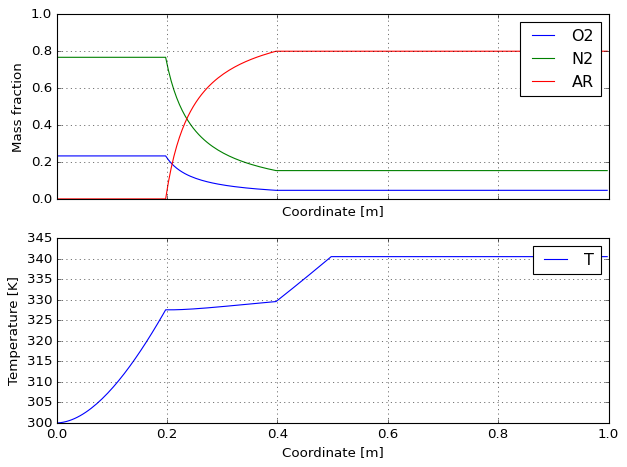

In [15]:
plot = model.reactor.quick_plot()
plot.axes[0].set_ylim(0, 1)
plot.resize(8, 6)

You can also access the data in base reactor for post-processing as desired:

In [16]:
model.reactor.states.to_pandas().head().T

0           1           2           3           4
z_cell       0.002500    0.007500    0.012500    0.017500    0.022500
V_cell       0.000039    0.000039    0.000039    0.000039    0.000039
Q_cell       1.177767    3.489592    5.744338    7.943414   10.088195
m_cell       0.000046    0.000046    0.000046    0.000046    0.000046
mdot_cell    0.050000    0.050000    0.050000    0.050000    0.050000
T          300.023321  300.092416  300.206156  300.363436  300.563179
density      1.171880    1.171610    1.171166    1.170553    1.169775
Y_O2         0.232909    0.232909    0.232909    0.232909    0.232909
Y_N2         0.767091    0.767091    0.767091    0.767091    0.767091
Y_AR         0.000000    0.000000    0.000000    0.000000    0.000000

## Counter-current flow reactors

The tooling required to compute a pair of reactors is already provided by `ReactorModel`; all we have to do is wrap a pair of reactors in `CounterCurrentReactors`. For convenience we store a copy of the axial coordinate (which is the same for both reactors). Notice here the introduction of `U`, a global heat transfer coefficient between phases, `Q`, the associated heat flux, and a relaxation manager.

In [17]:
class CounterCurrentReactors:
    """ Wrap a pair of reactors and exchange heat between them. """
    def __init__(self, z, V1, V2, U, alpha=0.8):
        self.z = z
        self.U = U

        self.r1 = ReactorModel(z, V1)
        self.r2 = ReactorModel(z, V2)

        self.Q = np.zeros_like(z)
        self.relax = RelaxUpdate(self.Q, alpha)

One cannot compute heat fluxes between reactors before having an initial temperature profile established (see it as an initial guess). Function `initialize` is provided for that end and must be called after mass flows have been setup.

In [18]:
def initialize(model):
    """ First solution for *initial guess*. """
    solve_reactor(model.r1, report=False)
    solve_reactor(model.r2, report=False)

There are two ways one can solve the relaxation problem here, each with its strengths and weaknesses; one could simply calculate calculate the flux, apply it to both reactors, and solve (`iter_direct`) or compose a series of flux and solution calculations (`iter_alternate`). When initial guess is not good enough, the alternating approach tends to deliver results in a more reliable fashion (because it is compatible with high relaxation factors), but it is slower. On the other hand, direct solution may converge faster as solution is already relaxed.

**IMPORTANT:** notice here that we get the reverse of `T2` to compute flux (as the reactors are in counter-current) and then `model.Q` is reversed againt to set heat flux to reactor 2. This class could easily be generalized by adding a flag on whether temperature and flux should be treated as is (co-current) or reversed.

In [19]:
def iter_direct(model, T1, T2):
    """ Strategy 1: compute flux, update both reactors. """
    model.Q[:] = model.relax(model.U * (T1 - T2[::-1]))

    model.r1.source.Q[:] = -1 * model.Q
    model.r2.source.Q[:] = +1 * model.Q[::-1]

    solve_reactor(model.r1, report=False)
    solve_reactor(model.r2, report=False)

In [20]:
def iter_alternate(model, T1, T2):
    """ Strategy 2: sequentally compute flux and update a reactor. """
    # Step 1:
    model.Q[:] = model.relax(model.U * (T1 - T2[::-1]))
    model.r1.source.Q[:] = -1 * model.Q
    solve_reactor(model.r1, report=False)
    T1 = model.r1.reactor.states.T

    # Step 2:
    model.Q[:] = model.relax(model.U * (T1 - T2[::-1]))
    model.r2.source.Q[:] = +1 * model.Q[::-1]
    solve_reactor(model.r2, report=False)

Based on the previous discussion, a mixed approach can be proposed: relax the problem with the alternating solution and move to direct one after a certain criteria or maximum number of iterations has been achieved. This is emulated in `solve_pair` provided below.

In [21]:
def solve_pair(model, method="alternate", *, max_alternate=np.inf,
               max_iter=50, patience=3):
    """ Iterativelly solve pair of reactors with method. """
    converged = StabilizeNvarsConvergenceCheck(
        n_vars=2, max_iter=max_iter, patience=patience)

    T1 = model.r1.reactor.states.T
    T2 = model.r2.reactor.states.T
    count_alt = 0

    while True:
        if converged([T1[-1], T2[-1]]):
            break

        match method:
            case "alternate":
                iter_alternate(model, T1, T2)
                count_alt += 1

                if count_alt >= max_alternate:
                    method = "other"
            case _:
                iter_direct(model, T1, T2)

        T1 = model.r1.reactor.states.T
        T2 = model.r2.reactor.states.T

A simple standard ploting function is provided for the counter-current reactor pair:

In [22]:
@standard_plot(shape=(3, 1), resized=(10, 8))
def plot_pair(pair, fig, ax):
    """ Plot pair of reactors in counter-current. """
    T1 = pair.r1.reactor.states.T
    T2 = pair.r2.reactor.states.T[::-1]

    cp1 = pair.r1.reactor.states.cp_mass
    cp2 = pair.r2.reactor.states.cp_mass[::-1]

    ax[0].plot(pair.z, T1, label="Cold fluid")
    ax[0].plot(pair.z, T2, label="Hot fluid")
    ax[1].plot(pair.z, cp1, label="Cold fluid")
    ax[1].plot(pair.z, cp2, label="Hot fluid")
    ax[2].plot(pair.z, -pair.Q)

    ax[0].set_xlabel("z [m]")
    ax[1].set_xlabel("z [m]")
    ax[2].set_xlabel("z [m]")

    ax[0].set_ylabel("$T$ [K]")
    ax[1].set_ylabel("$c_p$ [J/(kg.K)]")
    ax[2].set_ylabel("$Q$ [W]")

    ax[0].legend(loc=4)
    ax[1].legend(loc=2)

    fig.suptitle("Hot flow from right to left, cold flow left to right")

### Example - pair of coupled PFR

This second example replaces the user-defined heat flow function by a convective heat exchange through a fin separating the reactions; this is modeled through a heat transfer coefficient `h` which is made constant here for illustration purposes only. To test the robustness of the approach, a relativelly high dilution flow is applied to a concentrated region in reactor 2 (hot stream).

After building the reactor pair, inlet and distributed conditions and the reactors are initialized, *.i.e.* solved individually, before iterative solution is performed. The user may require a final solution step for printing reactor quantities in a table.

In [23]:
def solve_and_report(r1, r2):
    """ Solve both reactors with results reporting. """
    solve_reactor(r1, report=True) # O
    solve_reactor(r2, report=True)

In [24]:
def sample_pair(l=0.02, alpha=0.75, method="alternate", final_solve=False, **kwargs):
    """ Pair of reactors model sample. """
    # - PARAMETERS
    h = 100.0

    # - PROCESS
    T1 = 300         # Temperature in channel 1 [K]
    T2 = 600         # Temperature in channel 2 [K]
    Td = 450         # Temperature of argon in channel 2 [K]
    m1 = 0.005       # Mass flow in channel 1 [kg/s]
    m2 = 0.10        # Mass flow in channel 2 [kg/s]

    # - GEOMETRY
    D = 0.10   # Reactor diameter [m]
    L = 1.0    # Reactor length [m]

    # Volume of a single cell [m³]
    V = np.pi * (D / 2)**2 * l

    # Area of exchange between cells [m²]
    A = D * l

    # Discretize space and prepare inputs:
    z = dicretize_length(L, l)
    V1 = V2 = np.full_like(z, V)
    U = np.full_like(z, h * A)

    # Select region of reactor to apply dilution flow:
    dilute = slice(np.argmax(z > 0.15), np.argmax(z > 0.20) + 1)

    pair = CounterCurrentReactors(z, V1, V2, U, alpha=alpha)
    add_source(pair.r1, where=0, mdot=m1,  X=X_AIR, T=T1)
    add_source(pair.r2, where=0, mdot=m2,  X=X_AIR, T=T2)
    add_source(pair.r2, where=dilute, mdot=1.0*l,  X="AR: 1", T=Td)
    initialize(pair)

    solve_pair(pair, method, max_iter=50, patience=3, **kwargs)

    if final_solve:
        solve_and_report(pair.r1, pair.r2)

    return pair

For low relaxation values ($\alpha<0.5$), both methods may eventually converge under the same number of iterations.

In [25]:
pair = sample_pair(l=0.010, alpha=0.3, method="alternate", final_solve=True)

|----------------------|-----|---------------|
| Total mass flow rate | g/s | +5.000000e+00 |
| Total external power | W   | +1.216871e+03 |
| Final temperature    | K   | +5.372994e+02 |
|----------------------|-----|---------------|
| Total mass flow rate | g/s | +1.600000e+02 |
| Total external power | W   | -1.216871e+03 |
| Final temperature    | K   | +5.615588e+02 |


In [26]:
%%skipper MJ_SOLVE_FINEST
pair = sample_pair(l=0.010, alpha=0.3, method="not_alternate", final_solve=True)

Skipping cell: MJ_SOLVE_FINEST=True


Refining the grid for the present case has an impact of a few degrees over final solution (but takes much longer to solve), as illustrated below. Below 2 mm there is little change in the final solution and this value is a practical limit for grid refinement here.

In [27]:
%%skipper MJ_SOLVE_FINEST
pair = sample_pair(l=0.002, alpha=0.3, method="alternate", final_solve=True)

Skipping cell: MJ_SOLVE_FINEST=True


In [28]:
%%skipper MJ_SOLVE_FINEST
pair = sample_pair(l=0.001, alpha=0.1, method="alternate", final_solve=True, max_alternate=5)

Skipping cell: MJ_SOLVE_FINEST=True


Finally we display the results; for the hot stream we observe a sharp decrease in temperature (and associated specific heat capacity) due to argon dilution. Cold stream progressivelly heats up along the channel length as expected.

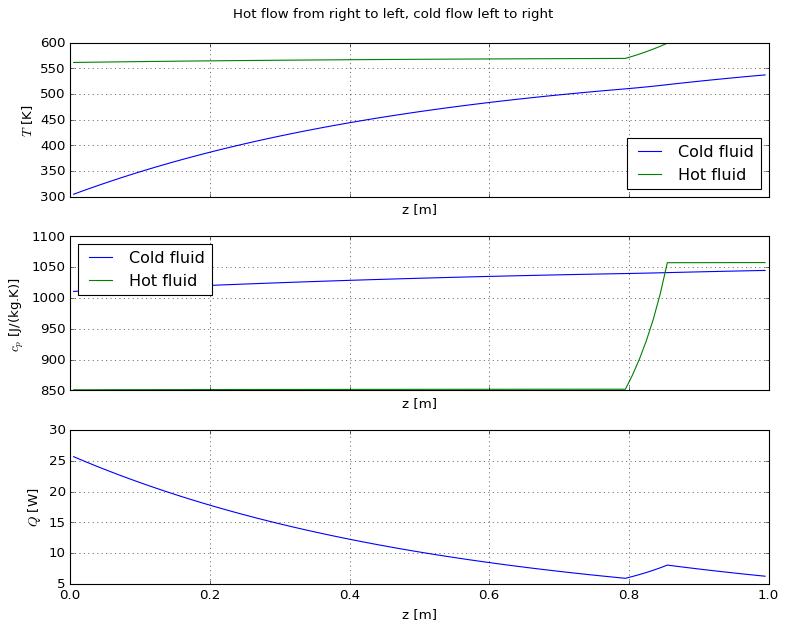

In [29]:
plot = plot_pair(pair)

## Adding losses to the environment

So far we have developed the ideas required to reach the final goal of conceiving a fully coupled system with a pair of reactors and walls. Again we proceed with a wrapper class which countains our problem variables, but in this case we fully develop it as a single block. Also, this time documentation is provided in the class itself as that seems clearer to the author in this case, and provides some closure to the study.

The main increment in problem solution here is the extra step of solving for the wall temperature, which can be found from the global flux definition:

$$
\dot{Q}_{w} = \dfrac{T_w - T_e}{R_{tot}}
\quad\text{where}\quad
R_{tot} = \dfrac{1}{hA}+\dfrac{1}{2\pi{}lk}\log\dfrac{R_{ext}}{R_{int}}
$$

We make use of the main takes of the previous sections, which have shown that alternating reactor solution order is not always an advantage; here the problem has been programmed to use direct solution. Relaxation is applied to reactor fluxes, but not to wall flux, which is computed from a balance of the relaxed quantities for the sake of energy conservation.

In [30]:
class FullCounterCurrentReactors:
    """ Add external losses to a pair of coupled reactors.

    Parameters
    ----------
    z: NDArray[np.float64]
        Coordinates of cell centers [m].
    V1: NDArray[np.float64]
        Volumes of cells of reactor 1 [m³].
    V2: NDArray[np.float64]
        Volumes of cells of reactor 2 [m³].
    U_inner: NDArray[np.float64]
        Global HTC between reactors [W/K].
    U_reac1: NDArray[np.float64]
        Global HTC between reactor 1 and wall [W/K].
    U_reac2: NDArray[np.float64]
        Global HTC between reactor 2 and wall [W/K].
    R_wall: NDArray[np.float64]
        Wall thermal resistance [K/W].
    alpha_: float = 0.8
        Relaxation factor for internal exchanges.
    Te: float = 300.0
        External environment temperature [K]
    """
    def __init__(self, z: NDArray[np.float64], V1: NDArray[np.float64],
                 V2: NDArray[np.float64], U_inner: NDArray[np.float64],
                 U_reac1: NDArray[np.float64], U_reac2: NDArray[np.float64],
                 R_wall: NDArray[np.float64], alpha: float = 0.8,
                 Te: float = 300.0) -> None:
        self.z = z
        self.r1 = ReactorModel(z, V1)
        self.r2 = ReactorModel(z, V2)

        self.Ui  = U_inner
        self.U1  = U_reac1
        self.U2  = U_reac2
        self.Rw  = R_wall

        self.Te  = Te
        self.Tw  = np.full_like(z, Te)

        self.q1w = np.zeros_like(z)
        self.q2w = np.zeros_like(z)
        self.q12 = np.zeros_like(z)
        self.Qw  = np.zeros_like(z)

        self.relax_1 = RelaxUpdate(self.r1.source.Q, alpha)
        self.relax_2 = RelaxUpdate(self.r2.source.Q, alpha)

    def _compute_balances(self, T1, T2):
        """ Evaluate balances of all phases in system. """
        # Compute all heat fluxes between system components.
        self.q12[:] = -self.Ui * (T1       - T2[::-1])
        self.q1w[:] = -self.U1 * (T1       - self.Tw)
        self.q2w[:] = -self.U2 * (T2[::-1] - self.Tw)

        self.r1.source.Q[:] = self.relax_1(+1 * self.q12        + self.q1w)
        self.r2.source.Q[:] = self.relax_2(-1 * self.q12[::-1]  + self.q2w[::-1])

        # XXX: use overall by balance (no relax for energy conservation!)
        self.Qw[:] = -(self.r1.source.Q + self.r2.source.Q[::-1])

    def _iter_direct(self, T1, T2):
        """ Strategy 1: compute flux, update both reactors. """
        self._compute_balances(T1, T2)

        # Solve both reactors with updated fluxes:
        solve_reactor(self.r1, report=False)
        solve_reactor(self.r2, report=False)

        # Solve steady-state radial heat transfer with resistance.
        self.Tw[:] = self.Te + self.Qw * self.Rw

    def _iter_alternate(self, T1, T2):
        """ Strategy 2: sequentally compute flux and update a reactor. """
        # Step 1: solve r1
        self._compute_balances(T1, T2)
        solve_reactor(self.r1, report=False)
        T1 = self.r1.reactor.states.T

        # Step 2: solve r2
        self._compute_balances(T1, T2)
        solve_reactor(self.r2, report=False)
        T2 = self.r2.reactor.states.T

        # Step 3: solve wall
        self._compute_balances(T1, T2)
        self.Tw[:] = self.Te + self.Qw * self.Rw

    def solve(self, method="direct", *, max_iter=50, patience=3, max_alternate=5):
        """ Iterativelly solve pair of reactors with wall loss. """
        converged = StabilizeNvarsConvergenceCheck(
            n_vars=3, max_iter=max_iter, patience=patience)
        count_alt = 0

        T1 = self.r1.reactor.states.T
        T2 = self.r2.reactor.states.T
        Tw = self.Tw

        while True:
            if converged([np.mean(T1), np.mean(T2), np.mean(Tw)]):
                break

            match method:
                case "direct":
                    self._iter_direct(T1, T2)
                case _:
                    self._iter_alternate(T1, T2)
                    count_alt += 1

                    if count_alt >= max_alternate:
                        method = "direct"

            T1 = self.r1.reactor.states.T
            T2 = self.r2.reactor.states.T
            Tw = self.Tw

    @standard_plot(shape=(2, 1), resized=(10, 8))
    def plot(self, fig, ax):
        """ Plot fully integrated system. """
        T1 = self.r1.reactor.states.T
        T2 = self.r2.reactor.states.T[::-1]

        ax[0].plot(self.z, T1, label="Cold fluid")
        ax[0].plot(self.z, T2, label="Hot fluid")
        ax[0].plot(self.z, reactor.Tw, label="Wall")

        ax[1].plot(self.z, self.q1w, label="$Q_{1,w}$")
        ax[1].plot(self.z, self.q2w, label="$Q_{2,w}$")
        ax[1].plot(self.z, self.q12, label="$Q_{1,2}$")

        ax[0].set_xlabel("z [m]")
        ax[1].set_xlabel("z [m]")

        ax[0].set_ylabel("$T$ [K]")
        ax[1].set_ylabel("$Q$ [W]")

        ax[0].legend(loc=4)
        ax[1].legend(loc=1)

        fig.suptitle("Hot flow from right to left, cold flow left to right")

### Example - environment coupling

In [31]:
def sample_full(l=0.02, alpha=0.3, method="direct"):
    """ Sample case with a pair of coupled reactor and wall losses. """
    # - PARAMETERS
    h_inner = 100.0  # HTC r1-r2 [W/(m².K)]
    h_reac1 = 10.0   # HTC r1-wall [W/(m².K)]
    h_reac2 = 50.0   # HTC r2-wall [W/(m².K)]
    h_shell = 10.0   # HTC shell-env [W/(m².K)]
    k_shell = 1.0    # Conductivity [W/(m.K)]

    # - PROCESS
    Te = 298         # Environment temperature [K]
    T1 = 300         # Temperature in channel 1 [K]
    T2 = 600         # Temperature in channel 2 [K]
    Td = 450         # Temperature of argon in channel 2 [K]
    m1 = 0.005       # Mass flow in channel 1 [kg/s]
    m2 = 0.10        # Mass flow in channel 2 [kg/s]

    # - GEOMETRY
    r = 0.05         # Internal radius [m]
    R = 0.07         # External radius [m]
    L = 1.00         # Length of reactor [m]

    # Exchange areas [m²]
    S_inner = 2 * r * l
    S_reacn = np.pi * r * l
    S_shell = 2 * np.pi * R * l

    # Semi-reactor volumes [m³]
    V_half = 0.5 * np.pi * r**2 * l

    # Discretize space and prepare inputs
    z = np.arange(l/2, L-0.99*l/2, l)
    V1 = V2 = np.full_like(z, V_half)
    U_inner = np.full_like(z, h_inner * S_inner)
    U_reac1 = np.full_like(z, h_reac1 * S_reacn)
    U_reac2 = np.full_like(z, h_reac2 * S_reacn)
    S_shell = np.full_like(z, h_shell * S_shell)

    R_shell = np.log(R / r) / (2 * np.pi * l * k_shell)
    R_env   = 1 / (S_shell * h_shell)
    R_total = R_shell + R_env

    # Select region of reactor to apply dilution flow:
    dilute = slice(np.argmax(z > 0.15), np.argmax(z > 0.20) + 1)

    reactor = FullCounterCurrentReactors(z, V1, V2, U_inner, U_reac1, U_reac2,
                                         R_total, alpha=alpha, Te=Te)

    add_source(reactor.r1, where=0, mdot=m1,  X=X_AIR, T=T1)
    add_source(reactor.r2, where=0, mdot=m2,  X=X_AIR, T=T2)
    add_source(reactor.r2, where=dilute, mdot=1.0*l,  X="AR: 1", T=Td)
    initialize(reactor)

    # XXX: max_alternate greater than default to test the approach alone!
    reactor.solve(method, max_iter=50, patience=3, max_alternate=50)
    solve_and_report(reactor.r1, reactor.r2)

    return reactor

In [32]:
reactor = sample_full(l=0.100, alpha=0.3)

|----------------------|-----|---------------|
| Total mass flow rate | g/s | +5.000000e+00 |
| Total external power | W   | +1.003972e+03 |
| Final temperature    | K   | +4.963894e+02 |
|----------------------|-----|---------------|
| Total mass flow rate | g/s | +3.000000e+02 |
| Total external power | W   | -2.210504e+03 |
| Final temperature    | K   | +5.216989e+02 |


In [33]:
reactor = sample_full(l=0.010, alpha=0.3, method="direct")

|----------------------|-----|---------------|
| Total mass flow rate | g/s | +5.000000e+00 |
| Total external power | W   | +1.153462e+03 |
| Final temperature    | K   | +5.251459e+02 |
|----------------------|-----|---------------|
| Total mass flow rate | g/s | +1.600000e+02 |
| Total external power | W   | -2.516963e+03 |
| Final temperature    | K   | +5.519201e+02 |


In [34]:
%%skipper MJ_SOLVE_FINEST
reactor = sample_full(l=0.010, alpha=0.3, method="alternate")

Skipping cell: MJ_SOLVE_FINEST=True


In [35]:
%%skipper MJ_SOLVE_FINEST
reactor = sample_full(l=0.001, alpha=0.3)

Skipping cell: MJ_SOLVE_FINEST=True


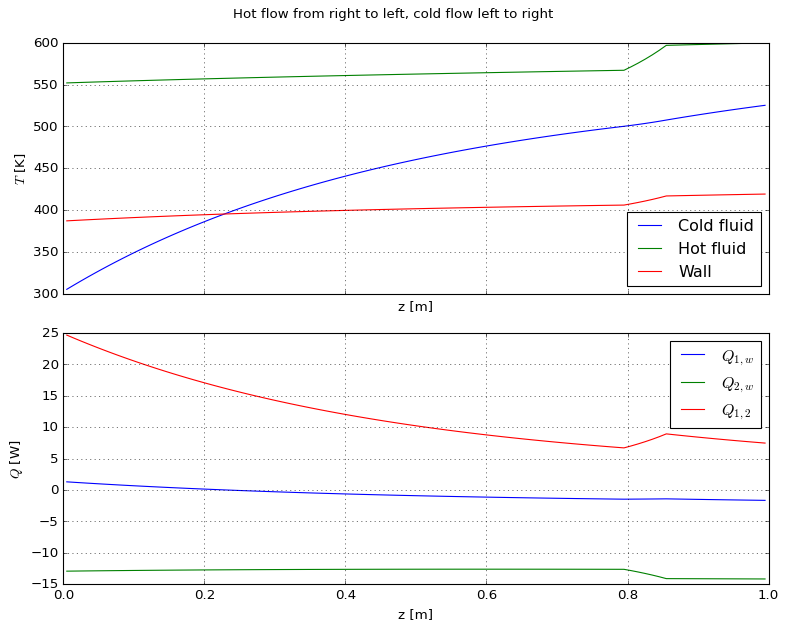

In [36]:
plot = reactor.plot()

## Registering flow for a single reactor

Below we develop further the idea into registering heat flows as an alternative to relaxation. The method may prove useful because heat flows are computed from current state of the reactors instead of an external guess.

In [37]:
def sample_register_single(l=0.001, report_first=False):
    """ Single reactor model sample. """
    # - PARAMETERS ----------------------------------------------------
    h = 200.0

    # - PROCESS -------------------------------------------------------
    T1 = 300         # Temperature in channel 1 [K]
    T2 = 600         # Temperature in channel 2 [K]
    Td = 450         # Temperature of argon in channel 2 [K]

    # - GEOMETRY ------------------------------------------------------
    D = 0.10   # Reactor diameter [m]
    L = 1.0    # Reactor length [m]

    # Volume of a single cell [m³]
    V = np.pi * (D / 2)**2 * l

    # Area of exchange between cells [m²]
    A = D * l

    # Discretize space and prepare inputs:
    z = dicretize_length(L, l)
    V = np.full_like(z, V)
    U = np.full_like(z, h * A)

    # - REGISTER ------------------------------------------------------

    def heat_flow(idx, T_reac):
        """ Compute heat flow at cell `idx` [W]. """
        return -U[idx] * (T_reac - T2)

    # - SETUP ---------------------------------------------------------
    # Select region of reactor to apply dilution flow:
    dilute = slice(np.argmax(z > 0.2), np.argmax(z > 0.4))

    # Create reactor with equal volume cells:
    model = ReactorModel(z, V=V)
    model.reactor.register_heat_flow(heat_flow)

    # Enforce a zero a power supply function:
    model.source.Q[:] = 0

    add_source(model, where=0, mdot=0.05, T=T1, X=X_AIR)
    add_source(model, where=dilute, mdot=1.0*l, T=Td, X="AR: 1")

    solve_reactor(model, report=False)
    solve_reactor(model, report=True)

    return model

### Example - prototype with a single reactor

In [38]:
model = sample_register_single(l=0.001)

|----------------------|-----|---------------|
| Total mass flow rate | g/s | +2.500000e+02 |
| Total external power | W   | +4.237303e+03 |
| Final temperature    | K   | +4.232112e+02 |


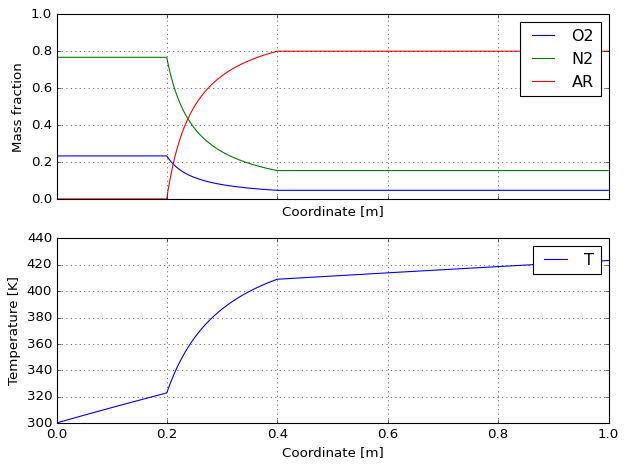

In [39]:
plot = model.reactor.quick_plot()
plot.axes[0].set_ylim(0, 1)
plot.resize(8, 6)

## Registering flow for a pair of reactors

As a last level of improvement, we generalize the approach for a pair of reactors. After some experimentation it was concluded that falling back to the alternating approach with intermediate wall solution lead to the best performance, probably because of decreased system stifness. Relaxing the wall heat flow allows for faster convergence.

In [40]:
class FullCounterCurrentReactorsWithRegister:
    """ Add external losses to a pair of coupled reactors.

    Parameters
    ----------
    z: NDArray[np.float64]
        Coordinates of cell centers [m].
    V1: NDArray[np.float64]
        Volumes of cells of reactor 1 [m³].
    V2: NDArray[np.float64]
        Volumes of cells of reactor 2 [m³].
    U_inner: NDArray[np.float64]
        Global HTC between reactors [W/K].
    U_reac1: NDArray[np.float64]
        Global HTC between reactor 1 and wall [W/K].
    U_reac2: NDArray[np.float64]
        Global HTC between reactor 2 and wall [W/K].
    R_wall: NDArray[np.float64]
        Wall thermal resistance [K/W].
    alpha_: float = 0.5
        Relaxation factor for internal exchanges.
    Te: float = 300.0
        External environment temperature [K]
    """
    def __init__(self, z: NDArray[np.float64], V1: NDArray[np.float64],
                 V2: NDArray[np.float64], U_inner: NDArray[np.float64],
                 U_reac1: NDArray[np.float64], U_reac2: NDArray[np.float64],
                 R_wall: NDArray[np.float64], alpha: float = 0.35,
                 Te: float = 300.0) -> None:
        self.z = z
        self.r1 = ReactorModel(z, V1)
        self.r2 = ReactorModel(z, V2)

        self.Ui  = U_inner
        self.U1  = U_reac1
        self.U2  = U_reac2
        self.Rw  = R_wall

        self.Te  = Te
        self.Tw  = np.full_like(z, Te)

        self.q1w = np.zeros_like(z)
        self.q2w = np.zeros_like(z)
        self.q12 = np.zeros_like(z)
        self.Qw  = np.zeros_like(z)

        self.relax = RelaxUpdate(self.Qw, alpha)

    # -----------------------------------------------------------------
    # STEPWISE
    # -----------------------------------------------------------------
    
    def _compute_balances(self, T1, T2):
        """ Evaluate balances of all phases in system. """
        # Compute all heat fluxes between system components.
        self.q12[:] = -self.Ui * (T1       - T2[::-1])
        self.q1w[:] = -self.U1 * (T1       - self.Tw)
        self.q2w[:] = -self.U2 * (T2[::-1] - self.Tw)

        self.r1.source.Q[:] = +1 * self.q12        + self.q1w
        self.r2.source.Q[:] = -1 * self.q12[::-1]  + self.q2w[::-1]
        self.Qw[:] = self.relax(-(self.r1.source.Q + self.r2.source.Q[::-1]))

    def _update_wall(self):
        """ Update wall solution with current state. """
        T1 = self.r1.reactor.states.T
        T2 = self.r2.reactor.states.T
        self._compute_balances(T1, T2)
        self.Tw[:] = self.Te + self.Qw * self.Rw

    # -----------------------------------------------------------------
    # WEAK COUPLING
    # -----------------------------------------------------------------

    def _get_cell_flows(self, i, T1, T2):
        """ Compute cell flows for a single pair. """
        q12 = -self.Ui[i] * (T1 - T2)
        q1w = -self.U1[i] * (T1 - self.Tw[i])
        q2w = -self.U2[i] * (T2 - self.Tw[i])

        if self._solve_wall:
            self.Tw[i] = self.Te - (q1w + q2w) * self.Rw[i]

        return q12, q1w, q2w

    # -----------------------------------------------------------------
    # CORE STEPS
    # -----------------------------------------------------------------
    
    def _heat_flow_1(self, k, T1, T2):
        q12, q1w, _ = self._get_cell_flows(k, T1, T2[self._N-k])
        return +1 * q12 + q1w
        
    def _heat_flow_2(self, k, T1, T2):
        q12, _, q2w = self._get_cell_flows(self._N-k, T1[self._N-k], T2)
        return -1 * q12 + q2w
    
    def _solve_r1(self, T2):
        def heat_flow(i, T): return self._heat_flow_1(i, T, T2)
    
        self.r1.source.Q[:] = 0.0
        self.r1.reactor.register_heat_flow(heat_flow)
        solve_reactor(self.r1, report=False)
        
    def _solve_r2(self, T1):
        def heat_flow(i, T): return self._heat_flow_2(i, T1, T)

        self.r2.source.Q[:] = 0.0
        self.r2.reactor.register_heat_flow(heat_flow)
        solve_reactor(self.r2, report=False)

    # -----------------------------------------------------------------
    # ALGORITHM SELECTION
    # -----------------------------------------------------------------
    
    def _iterate(self, N, method):
        """ Perform a single iteration of solution. """
        self._solve_wall = method.startswith("weak")
    
        match method:
            case "step_alt":
                self._solve_r1(self.r2.reactor.states.T)
                self._update_wall()
                
                self._solve_r2(self.r1.reactor.states.T)
                self._update_wall()
                
            case "step_seq":
                T1_now = self.r1.reactor.states.T
                T2_now = self.r2.reactor.states.T
                
                self._solve_r1(T2_now)
                self._update_wall()
                
                self._solve_r2(T1_now)
                self._update_wall()
                
            case "weak_alt":
                self._solve_r1(self.r2.reactor.states.T)
                self._solve_r2(self.r1.reactor.states.T)
                
            case "weak_seq":
                T1_now = self.r1.reactor.states.T
                T2_now = self.r2.reactor.states.T
                
                self._solve_r1(T2_now)
                self._solve_r2(T1_now)

            case _:
                raise ValueError(f"Unknown method {method}")

    # -----------------------------------------------------------------
    # API
    # -----------------------------------------------------------------

    def solve(self, method="solve_alt", *, max_iter=200, patience=3):
        """ Iterativelly solve pair of reactors with wall loss. """
        self._N = N = self.z.shape[0] - 1

        conv = ComposedStabilizedConvergence(
            3, n_vars=N+1, min_iter=50, max_iter=max_iter,
            patience=patience)

        while True:
            if conv(self.r1.reactor.states.T,
                    self.r2.reactor.states.T,
                    self.Tw):
                bal = np.abs(self.compute_residual())
                idx = np.argmax(bal)
                val = bal[idx]
                logging.info(f"Converged after {conv.n_iterations} iterations "
                             f"with maximum residual of {val:.6e} at cell {idx}")
                break

            self._iterate(N, method)

    def compute_residual(self):
        """ Evaluate reactor residual of energy flow. """
        T1 = self.r1.reactor.states.T
        T2 = self.r2.reactor.states.T
        self._compute_balances(T1, T2)
        
        Qw = -1 * (self.q1w + self.q2w)
        Q1 = self.r1.reactor.states.Q_cell
        Q2 = self.r2.reactor.states.Q_cell[::-1]

        return Q1 + Q2 + Qw
        
    @standard_plot(shape=(1, 1), resized=(10, 5))
    def plot_residual(self, fig, ax):
        """ Display residual of energy balance over length. """
        bal = self.compute_residual()
        ax[0].plot(self.z, bal)
        ax[0].set_xlabel("z [m]")
        ax[0].set_ylabel("Balance [W]")
        
    @standard_plot(shape=(2, 1), resized=(10, 8))
    def plot(self, fig, ax):
        """ Plot fully integrated system. """
        T1 = self.r1.reactor.states.T
        T2 = self.r2.reactor.states.T[::-1]

        ax[0].plot(self.z, T1, label="Cold fluid")
        ax[0].plot(self.z, T2, label="Hot fluid")
        ax[0].plot(self.z, reactor.Tw, label="Wall")

        ax[1].plot(self.z, self.q1w, label="$Q_{1,w}$")
        ax[1].plot(self.z, self.q2w, label="$Q_{2,w}$")
        ax[1].plot(self.z, self.q12, label="$Q_{1,2}$")

        ax[0].set_xlabel("z [m]")
        ax[1].set_xlabel("z [m]")

        ax[0].set_ylabel("$T$ [K]")
        ax[1].set_ylabel("$Q$ [W]")

        ax[0].legend(loc=4)
        ax[1].legend(loc=1)

        fig.suptitle("Hot flow from right to left, cold flow left to right")

### Example - extension to coupled system

In [41]:
def sample_register_full(l=0.02, method="method-2"):
    """ Sample case with a pair of coupled reactor and wall losses. """
    # - PARAMETERS
    h_inner = 100.0  # HTC r1-r2 [W/(m².K)]
    h_reac1 = 10.0   # HTC r1-wall [W/(m².K)]
    h_reac2 = 50.0   # HTC r2-wall [W/(m².K)]
    h_shell = 10.0   # HTC shell-env [W/(m².K)]
    k_shell = 1.0    # Conductivity [W/(m.K)]

    # - PROCESS
    Te = 298         # Environment temperature [K]
    T1 = 300         # Temperature in channel 1 [K]
    T2 = 600         # Temperature in channel 2 [K]
    Td = 450         # Temperature of argon in channel 2 [K]
    m1 = 0.005       # Mass flow in channel 1 [kg/s]
    m2 = 0.10        # Mass flow in channel 2 [kg/s]

    # - GEOMETRY
    r = 0.05         # Internal radius [m]
    R = 0.07         # External radius [m]
    L = 1.00         # Length of reactor [m]

    # Exchange areas [m²]
    S_inner = 2 * r * l
    S_reacn = np.pi * r * l
    S_shell = 2 * np.pi * R * l

    # Semi-reactor volumes [m³]
    V_half = 0.5 * np.pi * r**2 * l

    # Discretize space and prepare inputs
    z = np.arange(l/2, L-0.99*l/2, l)
    V1 = V2 = np.full_like(z, V_half)
    U_inner = np.full_like(z, h_inner * S_inner)
    U_reac1 = np.full_like(z, h_reac1 * S_reacn)
    U_reac2 = np.full_like(z, h_reac2 * S_reacn)
    S_shell = np.full_like(z, h_shell * S_shell)

    R_shell = np.log(R / r) / (2 * np.pi * l * k_shell)
    R_env   = 1 / (S_shell * h_shell)
    R_total = R_shell + R_env

    # Select region of reactor to apply dilution flow:
    dilute = slice(np.argmax(z > 0.15), np.argmax(z > 0.20) + 1)

    reactor = FullCounterCurrentReactorsWithRegister(
        z, V1, V2, U_inner, U_reac1, U_reac2, R_total, Te=Te, alpha=0.35)

    add_source(reactor.r1, where=0, mdot=m1,  X=X_AIR, T=T1)
    add_source(reactor.r2, where=0, mdot=m2,  X=X_AIR, T=T2)
    add_source(reactor.r2, where=dilute, mdot=1.0*l,  X="AR: 1", T=Td)
    initialize(reactor)

    reactor.r1.reactor.use_smooth_flux(False)
    reactor.r2.reactor.use_smooth_flux(False)

    reactor.solve(method)
    solve_and_report(reactor.r1, reactor.r2)

    return reactor

In [42]:
%%time
reactor = sample_register_full(l=0.010, method="weak_alt")

INFO:root:Converged after 50 iterations with maximum residual of 2.210593e-08 at cell 98


|----------------------|-----|---------------|
| Total mass flow rate | g/s | +5.000000e+00 |
| Total external power | W   | +1.153462e+03 |
| Final temperature    | K   | +5.251459e+02 |
|----------------------|-----|---------------|
| Total mass flow rate | g/s | +1.600000e+02 |
| Total external power | W   | -2.516963e+03 |
| Final temperature    | K   | +5.519201e+02 |
CPU times: user 7.24 s, sys: 134 ms, total: 7.37 s
Wall time: 7.24 s


In [43]:
%%time
reactor = sample_register_full(l=0.010, method="weak_seq")

INFO:root:Converged after 50 iterations with maximum residual of 2.201708e-08 at cell 99


|----------------------|-----|---------------|
| Total mass flow rate | g/s | +5.000000e+00 |
| Total external power | W   | +1.153462e+03 |
| Final temperature    | K   | +5.251459e+02 |
|----------------------|-----|---------------|
| Total mass flow rate | g/s | +1.600000e+02 |
| Total external power | W   | -2.516963e+03 |
| Final temperature    | K   | +5.519201e+02 |
CPU times: user 8.1 s, sys: 156 ms, total: 8.26 s
Wall time: 8.09 s


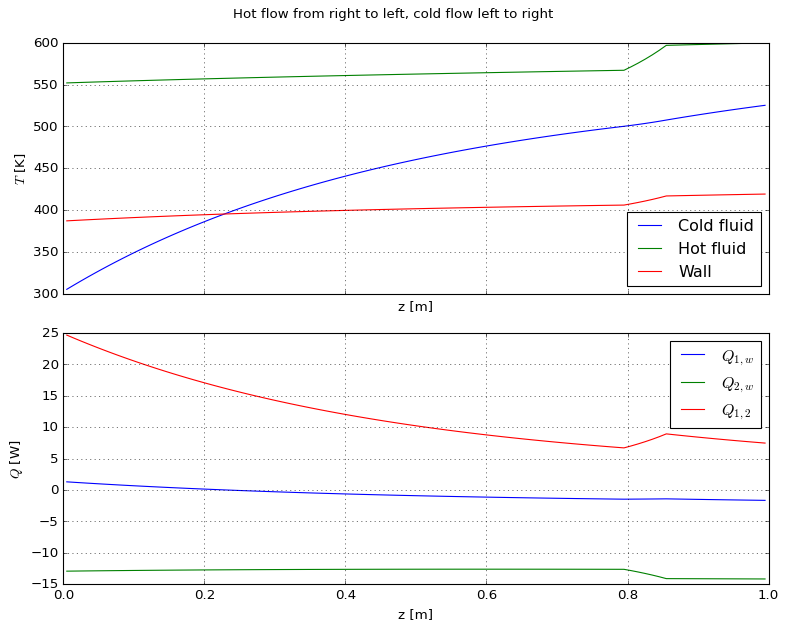

In [44]:
plot = reactor.plot()

In [45]:
%%time
reactor = sample_register_full(l=0.010, method="step_alt")

INFO:root:Converged after 50 iterations with maximum residual of 2.518874e-12 at cell 0


|----------------------|-----|---------------|
| Total mass flow rate | g/s | +5.000000e+00 |
| Total external power | W   | +1.153462e+03 |
| Final temperature    | K   | +5.251459e+02 |
|----------------------|-----|---------------|
| Total mass flow rate | g/s | +1.600000e+02 |
| Total external power | W   | -2.516963e+03 |
| Final temperature    | K   | +5.519201e+02 |
CPU times: user 6.5 s, sys: 88.3 ms, total: 6.59 s
Wall time: 6.51 s


In [46]:
%%time
reactor = sample_register_full(l=0.010, method="step_seq")

INFO:root:Converged after 50 iterations with maximum residual of 5.757173e-11 at cell 0


|----------------------|-----|---------------|
| Total mass flow rate | g/s | +5.000000e+00 |
| Total external power | W   | +1.153462e+03 |
| Final temperature    | K   | +5.251459e+02 |
|----------------------|-----|---------------|
| Total mass flow rate | g/s | +1.600000e+02 |
| Total external power | W   | -2.516963e+03 |
| Final temperature    | K   | +5.519201e+02 |
CPU times: user 7.16 s, sys: 179 ms, total: 7.34 s
Wall time: 7.2 s


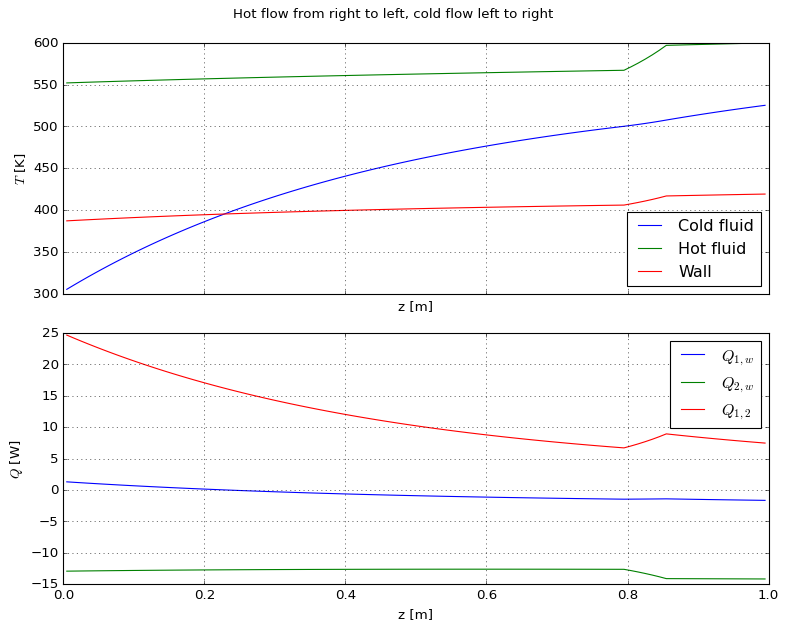

In [47]:
plot = reactor.plot()

In [48]:
%%time
reactor = sample_full(l=0.010, alpha=0.35, method="direct")

|----------------------|-----|---------------|
| Total mass flow rate | g/s | +5.000000e+00 |
| Total external power | W   | +1.153462e+03 |
| Final temperature    | K   | +5.251459e+02 |
|----------------------|-----|---------------|
| Total mass flow rate | g/s | +1.600000e+02 |
| Total external power | W   | -2.516963e+03 |
| Final temperature    | K   | +5.519201e+02 |
CPU times: user 3.5 s, sys: 26.9 ms, total: 3.53 s
Wall time: 3.5 s


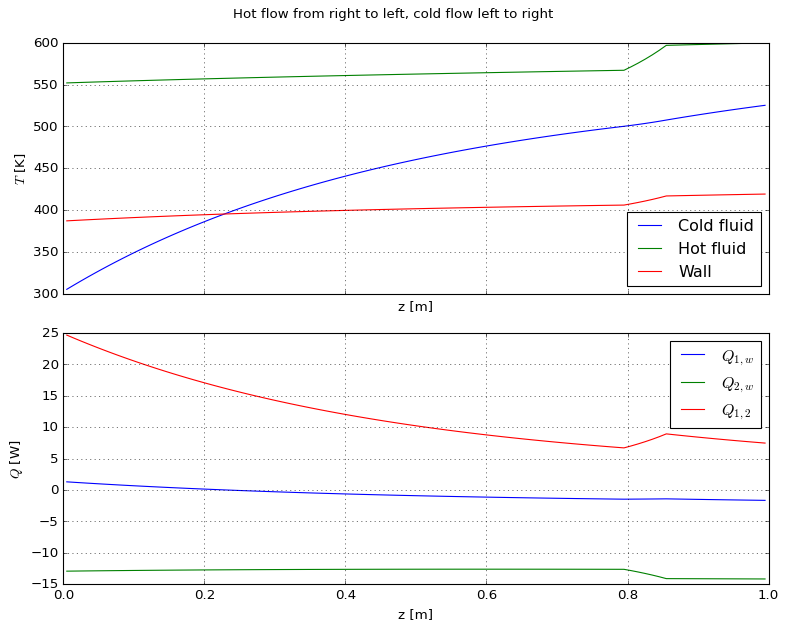

In [49]:
plot = reactor.plot()